<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_11_k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-means clustering with sklearn

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)

def cluster(X):
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  centers = kmeans.cluster_centers_

  return y_kmeans, centers

def classify(X):
  return kmeans.predict(X)

In [2]:
#@title K-means
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_clusters(X, y, center, xx, yy, Z):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='viridis')
  # see https://matplotlib.org/3.1.1/api/markers_api.html
  plt.scatter(center[:, 0], center[:, 1], c=range(len(center)), marker='s', s=200, alpha=0.7);
  
  # Put the result into a color plot
  n_classes = len(center)
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(n_classes + 1) - 0.5, cmap='viridis', zorder=1)
  
  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  y_kmeans, centers = cluster(X)

  # fit the estimator
  xlim = [-1.0, 1.0]
  ylim = [-1.0, 1.0]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  Z = classify(np.c_[xx.ravel(), yy.ravel()])

  fig = plot_clusters(X, y_kmeans, centers, xx, yy, Z)

  image_base64 = figure_to_base64(fig)
  return IPython.display.JSON({'image': image_base64})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.3)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }
  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Cluster
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)

#simplest custom k-means implementation

In [0]:
# a very basic implementation of k-means

from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, callback):
  # 1. Randomly choose clusters
  rng = np.random.RandomState()
  i = rng.permutation(X.shape[0])[:n_clusters]
  centers = X[i]
    
  while True:
    # 2a. Assign labels based on closest center
    labels = pairwise_distances_argmin(X, centers)

    # do callback
    callback(X, labels, centers)
    
    # 2b. Find new centers from means of points
    new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
    
    # 2c. Check for convergence
    if np.all(centers == new_centers):
        break
    centers = new_centers

In [2]:
#@title custom K-means
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_clusters(X, y, center):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='viridis')
  # see https://matplotlib.org/3.1.1/api/markers_api.html
  plt.scatter(center[:, 0], center[:, 1], c=range(len(center)), marker='s', s=200, alpha=0.7);
    
  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

video = []

def im_gen(X, y_kmeans, centers):
  global video
  fig = plot_clusters(X, y_kmeans, centers)
  image_base64 = figure_to_base64(fig)
  video.append(image_base64)

def invoke(pts, depth):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  #y_kmeans, centers = cluster(X)
  #fig = plot_clusters(X, y_kmeans, centers)
  global video
  video = []
  find_clusters(X, int(depth), im_gen) # change n_clusters later
  #image_base64 = figure_to_base64(fig)
  return IPython.display.JSON({'images': video})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();
    var frames = [];
    var frame_index = 0;

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.3)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    function advance()
    {
      if (frames.length <= 0)
        return;
      if (frame_index < frames.length - 1)
        frame_index += 1;
      bg_image.src = 'data:image/  png;base64,' + frames[frame_index];
    }

    var timer, timer_video;
    function init() {
      timer = setInterval(draw, 10);
      timer_video = setInterval(advance, 1000);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    var cur_depth = 1;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth], {});
      params = result.data['application/json'];
      frames = params.images;
      frame_index = 0;
      bg_image.src = 'data:image/  png;base64,' + params.images[0];
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Number of clusters:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
   <br><br>
    <button type="button" onclick="calculate();">
      Cluster
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)

#iris clustering

ACCURACY =  0.8933333333333333


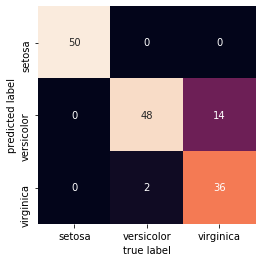

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data

from sklearn.decomposition import PCA

model = PCA(3)
projected = model.fit_transform(X)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(projected)
y = kmeans.predict(projected)


import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[d] for d in y]

fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=projected[:, 0], y=projected[:, 1], z=projected[:, 2], mode='markers', 
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

fig.update_layout(width=600, height=600, autosize=False, 
                  title_text="3-component PCA for your dataset",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)
      
fig.show()

#match clusters with real labels
from scipy.stats import mode

labels = np.zeros_like(y)
for i in range(10):
    mask = (y == i)
    labels[mask] = mode(iris.target[mask])[0]
    
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(iris.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.ylim(3.0, 0.0)
plt.xlabel('true label')
plt.ylabel('predicted label');

# and check the accuracy
from sklearn.metrics import accuracy_score
print("ACCURACY = ", accuracy_score(iris.target, labels))